In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
import json
import os
import glob
from geopy.geocoders import Nominatim
import re
import pandas as pd
from torchvision.io import read_image
from sklearn.preprocessing import LabelEncoder
from torch.utils.tensorboard import SummaryWriter
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
import math
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True   #OTHERWISE TRUNCATED IMAGE FILE ERROR SOMEWHERE IN ENUMERATE(DATALOADER)!!!!

In [2]:
writer = SummaryWriter()

In [3]:
torch.cuda.current_device()
torch.cuda.set_device(3)
print(torch.cuda.mem_get_info(torch.cuda.current_device()))
device = torch.cuda.current_device()

(94856867526528, 94856774457508)


In [4]:
# Hyper-parameters 
num_epochs = 80
batch_size = 16
learning_rate = 0.01

In [6]:
#READ THE LABELS.CSV FILE GENERATED IN PREPROCESSING.IPYNB, HEADER ALREADY GONE HERE!!!
image_id_and_labels = pd.read_csv('ids_and_labels.csv',delimiter=',',header=1)
#print(image_id_and_labels.values)
image_id_and_labels_arr = np.array(image_id_and_labels.values)
#print(image_id_and_labels_arr)

In [7]:
#ENCODE THE COUNTRY LABELS SO THAT DATASET CAN READ THEM As TENSORS
label_encoder = LabelEncoder()
image_id_and_labels_encoded = image_id_and_labels_arr.copy()
label_encoder.fit(image_id_and_labels_encoded[:,3])
encoded_countries = label_encoder.transform(image_id_and_labels_encoded[:,3])
#print(encoded_countries)
image_id_and_labels_encoded[:,3] = encoded_countries
print(image_id_and_labels_encoded)

[['global_monthly_2018_09_mosaic_L15-0331E-1257N_1327_3160_13.tif' nan
  'California' 18]
 ['global_monthly_2018_06_mosaic_L15-0331E-1257N_1327_3160_13.tif' nan
  'California' 18]
 ['global_monthly_2018_11_mosaic_L15-0331E-1257N_1327_3160_13.tif' nan
  'California' 18]
 ...
 ['global_monthly_2019_01_mosaic_L15-1848E-0793N_7394_5018_13.tif'
  'Melbourne' 'Victoria' 1]
 ['global_monthly_2018_12_mosaic_L15-1848E-0793N_7394_5018_13.tif'
  'Melbourne' 'Victoria' 1]
 ['global_monthly_2019_06_mosaic_L15-1848E-0793N_7394_5018_13.tif'
  'Melbourne' 'Victoria' 1]]


In [8]:
#TRAIN-VAL SPLIT AND SAVE AS SEPERATE CSV FILES

#ids_labels_train, ids_labels_val = train_test_split(image_id_and_labels_encoded, test_size=0.2, random_state=42)

stratSplit = StratifiedShuffleSplit(n_splits=1, test_size = 0.25, random_state=42)
for train_idx, test_idx in stratSplit.split(image_id_and_labels_encoded, np.zeros(len(image_id_and_labels_encoded))):
    ids_labels_train, ids_labels_val = image_id_and_labels_encoded[train_idx], image_id_and_labels_encoded[test_idx]
    

print(len(ids_labels_train))
print(len(ids_labels_val))
np.savetxt("ids_and_labels_train.csv", ids_labels_train, delimiter=",", fmt='%s')
np.savetxt("ids_and_labels_val.csv", ids_labels_val, delimiter=",", fmt='%s')

1066
356


In [9]:
print(len(np.unique(ids_labels_train[:,3])))
print(len(np.unique(ids_labels_val[:,3])))
print(len(np.unique(image_id_and_labels_encoded[:,3])))  #NO OF COUNTRIES OVERALL

31
31
31


In [18]:
#CUSTOM DATASET CLASS
class SN7Dataset(Dataset):
    
    def __init__(self, transform=None, train=True):
        
        if train == True:
            self.img_ids_labels = pd.read_csv("ids_and_labels_train.csv", header = None) 
        else:
            self.img_ids_labels = pd.read_csv("ids_and_labels_val.csv", header = None)
            
        self.img_dir = '/local/home/stuff/datasets/Challenge_7/train'
        self.transform = transform
        
    def __getitem__(self, idx):
        
        image_id = self.img_ids_labels.iloc[idx, 0]
        pattern = "mosaic_(.*?).tif"
        location_id = re.search(pattern, image_id).group(1)
        #print(image_id)
        #print(location_id)
        img_path = os.path.join(self.img_dir, location_id, 'images', image_id )
        image = torchvision.transforms.ToTensor()(Image.open(img_path))[0:3,:,:]  #TAKE RGB CHANNELS ONLY FOR RESNET COMPATIBILITY!!!
        
        image_padded = torch.nn.functional.pad(image, pad=(0, 1024 - image.shape[2], 0, 1024 - image.shape[1]))
        patches = image_padded.unfold(1, 256, 256).unfold(2, 256, 256)
        patches = patches.reshape(3, -1, 256, 256)
        patches = patches.permute(1,0,2,3)
        
        label = torch.from_numpy(np.asarray(self.img_ids_labels.iloc[idx, 3]))*torch.ones(patches.size(0))
        
        #patches = patches.view(-1, 3, 256, 256)
        #label = label.flatten()
        #label = label.type(torch.LongTensor)
        
        if self.transform:
            patches = self.transform(patches)
        #if self.target_transform:
            #label = self.target_transform(label)
            
        
        return patches, label
        
    def __len__(self):
        
        return len(self.img_ids_labels)

In [19]:
#INSTANTIATE DATASETS
transform = transforms.Compose([torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])   #OTHERWISE SOME IMAGES 1024, SOME 1023!!!

train_dataset = SN7Dataset(train=True, transform = transform)
val_dataset = SN7Dataset(train=False, transform = transform)

train_loader = DataLoader(dataset=train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(dataset=val_dataset, batch_size = batch_size, shuffle = True)

#CHECK FOR TRAIN
#first_data = train_dataset[345]
#img, label = first_data
#plt.imshow(img.permute(1,2,0))     #OTHER WAY TO PLOT????????
#print(label_encoder.inverse_transform(label.detach().reshape(-1,1)))
#print(img.shape)
#print(type(img))
#print(type(label))


dataiter = iter(train_loader)
data = dataiter.next()
imgs, labels = data
print(imgs.shape)
print(labels.shape)

#for i in range(6):
#    plt.subplot(2,3,i+1)
#    plt.imshow(np.transpose(imgs[i]))
#    print(label_encoder.inverse_transform(labels[i].detach().reshape(-1,1)))
#plt.show()

#print(len(train_dataset))

torch.Size([16, 16, 3, 256, 256])
torch.Size([16, 16])


In [20]:
#CHECK FOR VAL

#first_data = val_dataset[271]
#img, label = first_data
#plt.imshow(img.permute(1,2,0))     #OTHER WAY TO PLOT????????
#print(label_encoder.inverse_transform(label.detach().reshape(-1,1)))
#print(img.shape)
#print(type(img))
#print(type(label))


#dataiter = iter(val_loader)
#data = dataiter.next()
#imgs, labels = data
#print(imgs.shape)
#print(labels.shape)

#for i in range(6):
#    plt.subplot(2,3,i+1)
#    plt.imshow(np.transpose(imgs[i]))
#    print(label_encoder.inverse_transform(labels[i].detach().reshape(-1,1)))
#plt.show()

#print(len(val_dataset))

torch.Size([256, 3, 256, 256])
tensor([11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 18, 18,
        18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
        18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 23, 23, 23, 23, 23, 23,
        23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 29, 29, 29, 29, 29, 29, 29, 29,
        29, 29, 29, 29, 29, 29, 29, 29, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
        18, 18, 18, 18, 18, 18,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5, 29, 29,
        29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, 29, 29, 29, 29, 29, 29,
        29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 25, 25, 25, 25, 25, 25, 25, 25,
        2

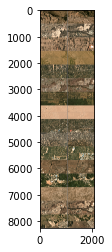

In [21]:
#CHECK FOR NORMALIZED IMAGES

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.view(-1,3,256,256)   #MAKES THE EFFECTIVE BATCH SIZE: BACTH_SIZE*16 !!!!
labels = labels.flatten().int()
print(images.shape)
print(labels)

# show images
imshow(torchvision.utils.make_grid(images))

In [22]:
#MODEL, LOSS AND OPTIMIZER
model = torchvision.models.resnet18().to(device)  #NOT PRETRAINED!
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [16]:
#DATA PARALLELISM FOR MULTİPLE GPUs
device = f'cuda:{model.device_ids[0]}'
model = nn.DataParallel(torchvision.models.resnet18(), device_ids = [2, 3]).to(device)
#NOTE: LOSS DIDNT DECREASE IN THIS CASE, %0 ACCURACY FOR ALL CLASSES!!!!

AttributeError: 'ResNet' object has no attribute 'device_ids'

In [17]:
#TRAINING LOOP
n_total_steps = len(train_loader)
running_loss = 0.0
running_correct = 0
checkpoints = 30
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        images = images.view(-1, 3, 256, 256)    
        labels = labels.flatten()
        labels = labels.type(torch.LongTensor)
        
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #scheduler.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        running_correct += (predicted == labels).sum().item()

        if (i+1) % checkpoints == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
            writer.add_scalar('training_loss', running_loss/checkpoints, epoch * n_total_steps + i)
            running_accuracy = running_correct/checkpoints/predicted.size(0)
            writer.add_scalar('accuracy', running_accuracy, epoch * n_total_steps + i)
            running_loss = 0.0
            running_correct = 0

writer.flush()
writer.close()

print('Finished Training')

Epoch [1/80], Step [30/67], Loss: 3.2367


KeyboardInterrupt: 

In [8]:
#print(type(ids_labels_val[:,3]))
val_classes = label_encoder.inverse_transform(ids_labels_val[:,3].astype('int'))
print(val_classes)
classes = np.unique(val_classes)
#print(len(classes))

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(len(classes))]
    n_class_samples = [0 for i in range(len(classes))]
    for images, labels in val_loader:
        
        images = images.view(-1, 3, 256, 256)     
        labels = labels.flatten()
        labels = labels.type(torch.LongTensor)
        
        images = images.to(device)  
        #print(labels.shape)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(len(labels)):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(len(classes)):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

NameError: name 'ids_labels_val' is not defined

In [21]:
torch.save(model.state_dict(),'supervised_model_patch.pth')

In [22]:
#MAY NEED TO SPLIT DATA WITH BALANCED CLASSES!!!(EQUAL NUM OF SAMPLES FROM EACH CLASS)
torch.cuda.empty_cache()